<a href="https://colab.research.google.com/github/pvst07/Fake-Talk-Detector-Project/blob/main/FakeTalk_Detector_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

Install Kaggle

In [ ]:
from google.colab import files
files.upload()  # Upload file kaggle.json
!pip install kaggle

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download and Unzip datasets

In [ ]:
!kaggle datasets download -d chayuri/deepfake-voice-segmented --unzip

Dataset URL: https://www.kaggle.com/datasets/chayuri/deepfake-voice-segmented
License(s): MIT
 99% 3.67G/3.69G [00:51<00:00, 136MB/s]
100% 3.69G/3.69G [00:51<00:00, 76.2MB/s]


Import

In [ ]:
# Standard Library
import os
import random
import shutil
import warnings
import zipfile
from glob import glob
from pathlib import Path

# Third-party Libraries
import librosa
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import soundfile as sf
from PIL import Image
from tabulate import tabulate
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

# PyTorch
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# TorchVision
import torchvision.transforms as T
from torchvision import models
from torchvision.models import ResNet34_Weights, resnet34
from torchvision.transforms import Resize, ToPILImage, ToTensor
from torchvision.transforms.functional import to_pil_image, to_tensor

Extract Collected File

In [ ]:
zip_path = "fake_collected.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
 zip_ref.extractall("/content")

zip_path = "real_collected.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content")


Rename

In [ ]:
rename = {

    "segmented_voices": "data"
}

base_path = "/content"

for old_name, new_name in rename.items():
    old_path = os.path.join(base_path, old_name)
    new_path = os.path.join(base_path, new_name)

    if os.path.exists(old_path):
        if not os.path.exists(new_path):
            os.rename(old_path, new_path)
            print(f"✅ Renamed: {old_name} → {new_name}")
        else:
            print(f"⚠️ Skip: {new_name} already exists")
    else:
        print(f"❌ Not found: {old_name}")


✅ Renamed: segmented_voices → data


Divide audio (.wav) into 5-second segments and split into training, validation, and test sets

In [ ]:
sr = 16000
duration = 5.0  # seconds
fixed_samples = int(sr * duration)

# set path
fake_base = Path("/content/fake_collected")
real_base = Path("/content/real_collected")
output_base = Path("/content/split_data")

# set split data plan
split_data1 = {
    "train": {
        "FAKE": [1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 19],
        "REAL": [1, 2, 3, 4,7,8,9,10]
    },
    "val": {
        "FAKE": [5, 15, 16],
        "REAL": [5]
    },
    "test": {
        "FAKE": [6, 17, 18],
        "REAL": [6]
    }
}

split_data2 = {
    "train": {
        "REAL": ["biden-original", "obama-original", "ryan-original", "taylor-original", "musk-original", "linus-original"],
        "FAKE": ["Obama-to-Biden", "biden-to-Obama", "musk-to-margot", "ryan-to-taylor", "taylor-to-ryan", "linus-to-taylor"]
    },
    "val": {
        "REAL": ["margot-original"],
        "FAKE": ["margot-to-musk"]
    },
    "test": {
        "REAL": ["trump-original"],
        "FAKE": ["trump-to-Obama"]
    }
}

In [ ]:
for split, categories in split_data1.items():                 # split = [train, val, test] | categories = [REAL, FAKE]
    for label, speaker_ids in categories.items():             # label = REAL / FAKE | speaker_names = [6, 17, 18]
        indices = split_data1[split][label]                   # indicate = 6 / 7/ 8
        base_path = fake_base if label == "FAKE" else real_base  # set path to find audio (.wav) file

        for idx in tqdm(indices, desc=f"{split}/{label}"):
            filename = f"speaker_{label.lower()}_{idx:02d}.wav"  # set files name ex. speaker_06_fake_001.wav
            wav_file = base_path / filename  # Set the file path for the WAV file

            if not wav_file.exists():
                print(f"⚠️ File {wav_file} not found. Skipping.")
                continue

            # Load audio
            y, _ = librosa.load(wav_file, sr=sr)
            total_duration = len(y) / sr
            num_segments = int(np.ceil(total_duration / duration))

            # create folder ex. collected_fake_speaker_06
            folder_name = f"collected_{label.lower()}_speaker{idx:02d}"
            out_dir = output_base / split / label.lower() / folder_name # Set the folder path ex. /content/split_data/train/fake/collected_fake_speaker016
            out_dir.mkdir(parents=True, exist_ok=True)

            for seg_idx in range(num_segments):
                start_sample = int(seg_idx * duration * sr)
                end_sample = int(min((seg_idx + 1) * duration * sr, len(y)))
                segment = y[start_sample:end_sample]

                # Pad with zeros if shorter than 5 seconds
                if len(segment) < fixed_samples:
                    pad_width = fixed_samples - len(segment)
                    segment = np.pad(segment, (0, pad_width))

                out_filename = f"speaker_{idx:02d}_{label.lower()}_{seg_idx+1:03d}.wav"
                out_path = out_dir / out_filename

                sf.write(out_path, segment, sr)


test/REAL: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


In [ ]:
base_path = Path("/content/data")
output_base = Path("/content/split_data")

for split, categories in split_data2.items():
    for label, folders in categories.items():
        label_dir = "FAKE" if label == "FAKE" else "REAL"
        for folder in folders:
            input_folder = base_path / label_dir / folder
            output_folder = output_base / split / label.lower() / folder
            output_folder.mkdir(parents=True, exist_ok=True)

            wav_files = list(input_folder.glob("*.wav"))
            for wav_file in tqdm(wav_files, desc=f"{split}/{folder}"):
                try:
                    y, _ = librosa.load(wav_file, sr=sr)
                    if len(y) < fixed_samples:
                        pad_width = fixed_samples - len(y)
                        y = np.pad(y, (0, pad_width))
                    # save files to split_data with the same name
                    sf.write(output_folder / wav_file.name, y, sr)
                except Exception as e:
                    print(f"Error processing {wav_file}: {e}")


test/trump-to-Obama: 100%|██████████| 120/120 [00:01<00:00, 69.12it/s]


Show Structure Folders

In [ ]:
def print_folder_structure(root_dir, indent=0, max_files=1):
    prefix = "    " * indent
    print(f"{prefix}{os.path.basename(root_dir)}/")

    try:
        items = sorted(os.listdir(root_dir))
    except NotADirectoryError:
        print(f"{prefix}  - {os.path.basename(root_dir)}")
        return

    files = [f for f in items if os.path.isfile(os.path.join(root_dir, f))]
    dirs = [d for d in items if os.path.isdir(os.path.join(root_dir, d))]

    for file in files[:max_files]:
        print(f"{prefix}    - {file}")
    if len(files) > max_files:
        print(f"{prefix}    ... ({len(files)} files)")

    for dir in dirs:
        print_folder_structure(os.path.join(root_dir, dir), indent + 1, max_files)

print_folder_structure("/content/split_data")


split_data/
    test/
        fake/
            collected_fake_speaker06/
                - speaker_06_fake_001.wav
                ... (60 files)
            collected_fake_speaker17/
                - speaker_17_fake_001.wav
                ... (16 files)
            collected_fake_speaker18/
                - speaker_18_fake_001.wav
                ... (20 files)
            trump-to-Obama/
                - segment_0.wav
                ... (120 files)
        real/
            collected_real_speaker06/
                - speaker_06_real_001.wav
                ... (60 files)
            trump-original/
                - segment_5371.wav
                ... (121 files)
    train/
        fake/
            Obama-to-Biden/
                - segment_3769.wav
                ... (120 files)
            biden-to-Obama/
                - segment_2923.wav
                ... (120 files)
            collected_fake_speaker01/
                - speaker_01_fake_001.wav
                ... (60 

Count Files

In [ ]:
def count_files_safe(path):
    try:
        return sum(len(files) for _, _, files in os.walk(path))
    except FileNotFoundError:
        print(f"⚠️ Directory not found: {path}")
        return 0
    except Exception as e:
        print(f"⚠️ Error counting files in {path}: {str(e)}")
        return 0

base_path = "/content/split_data"
datasets = {
    "Train": {"real": "train/real", "fake": "train/fake"},
    "Validation": {"real": "val/real", "fake": "val/fake"},
    "Test": {"real": "test/real", "fake": "test/fake"}
}

# count all files
for dataset in datasets:
    real_path = os.path.join(base_path, datasets[dataset]["real"])
    fake_path = os.path.join(base_path, datasets[dataset]["fake"])

    datasets[dataset]["real_count"] = count_files_safe(real_path)
    datasets[dataset]["fake_count"] = count_files_safe(fake_path)

# create table
table_data = []
total_real = 0
total_fake = 0

for dataset, data in datasets.items():
    real = data["real_count"]
    fake = data["fake_count"]
    total_real += real
    total_fake += fake
    table_data.append([dataset, real, fake])

table_data.append(["All", total_real, total_fake])

print("Split Data")
print(tabulate(table_data,
              headers=["Dataset", "Real", "Fake"],
              tablefmt="grid",
              numalign="center",
              stralign="center"))



Normalize and Augment Data
+------------+--------+--------+
|  Dataset   |  Real  |  Fake  |
+============+========+========+
|   Train    |  1073  |  1032  |
+------------+--------+--------+
| Validation |   76   |  111   |
+------------+--------+--------+
|    Test    |  181   |  216   |
+------------+--------+--------+
|    All     |  1330  |  1359  |
+------------+--------+--------+


Normalize ang Data Augmentation

In [ ]:
# set paths
src_root = "split_data"
dst_root = "normalize&augment_data"

# Normalization
def normalize_audio(audio):
    max_val = np.max(np.abs(audio))
    if max_val > 0:
        audio = audio / max_val
    return audio

# Augmentation
def add_noise(audio, sr=None):
    noise_factor = random.uniform(0.003, 0.01)
    noise = np.random.randn(len(audio))
    return normalize_audio(audio + noise_factor * noise)

def pitch_shift(audio, sr):
    n_steps = random.choice([-2, -1, 1, 2])
    return librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=n_steps)

def volume_change(audio, sr=None):
    gain = random.uniform(0.8, 1.5)
    return normalize_audio(audio * gain)

def time_stretch(audio, sr=None):
    rate = random.uniform(0.9, 1.1)
    stretched = librosa.effects.time_stretch(y=audio, rate=rate)
    return normalize_audio(stretched)

# Augmentation selector
def random_augment(audio, sr):
    aug_functions = {
        "noise":   lambda x, _ : add_noise(x),
        "pitch":   lambda x, sr: pitch_shift(x, sr),
        "volume":  lambda x, _ : volume_change(x),
        "stretch": lambda x, _ : time_stretch(x),
    }

    # choose 3 out of 4
    selected_keys = random.sample(list(aug_functions.keys()), k=3)
    augmented_versions = []

    for key in selected_keys:
        try:
            new_audio = aug_functions[key](audio, sr)
            augmented_versions.append((f"_{key}", new_audio))
        except Exception as e:
            print(f"❌ Augmentation error ({key}): {e}")

    return augmented_versions

# Create folder structure
print("Creating folder structure...")
for root, dirs, files in os.walk(src_root):
    for d in dirs:
        src_dir = os.path.join(root, d)
        relative_path = os.path.relpath(src_dir, src_root)
        dst_dir = os.path.join(dst_root, relative_path)
        os.makedirs(dst_dir, exist_ok=True)

# Collect all .wav file paths
all_wav_files = []
for root, dirs, files in os.walk(src_root):
    for file in files:
        if file.lower().endswith('.wav'):
            src_file = os.path.join(root, file)
            all_wav_files.append(src_file)

# Process and augment files with progress bar
from tqdm import tqdm
bar = tqdm(all_wav_files, bar_format="{l_bar}{bar:40}{r_bar}", colour="white")

saved_files = []

for src_file in bar:
    bar.set_description(f"Processing: {os.path.basename(src_file)}")

    relative_path = os.path.relpath(src_file, src_root)
    dst_file = os.path.join(dst_root, relative_path)

    # Load and normalize audio
    audio, sr = librosa.load(src_file, sr=None)
    audio_norm = normalize_audio(audio)

    # Save normalized file
    sf.write(dst_file, audio_norm, sr)
    saved_files.append(dst_file)

    # Augment only training data
    if "train" in src_file:
        base, ext = os.path.splitext(dst_file)
        aug_list = random_augment(audio_norm, sr)
        for suffix, aug_audio in aug_list:
            aug_path = f"{base}{suffix}{ext}"
            sf.write(aug_path, aug_audio, sr)
            saved_files.append(aug_path)

print(f"\n✅ Normalization and augmentation completed successfully — {len(saved_files)} files saved.")


Creating folder structure...


Processing: segment_5298.wav: 100%|████████████████████████████████████████| 2689/2689 [02:42<00:00, 16.57it/s]


✅ Normalization and augmentation completed successfully — 9004 files saved.


Converge audio (.wav file) to log mel spectrogram

In [ ]:
# set path
audio_root = "normalize&augment_data"
spec_root = "final_data"

SR = 22050
N_FFT = 1024
HOP_LENGTH = 512
WIN_LENGTH = 1024
N_MELS = 128
TARGET_TIME_LEN = 128

resize_224 = Resize((224, 224))
to_tensor = ToTensor()
to_pil = ToPILImage()

# tranfer .wav file to Log Mel Spectrogram
def create_logmel_spectrogram(audio_path, save_path):
    try:
        y, _ = librosa.load(audio_path, sr=SR)

        mel_spec = librosa.feature.melspectrogram(
            y=y,
            sr=SR,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            win_length=WIN_LENGTH,
            n_mels=N_MELS,
            power=2.0
        )

        logmel = librosa.power_to_db(mel_spec, ref=np.max)
        logmel_norm = (logmel - logmel.min()) / (logmel.max() - logmel.min())

        tensor = torch.FloatTensor(logmel_norm).unsqueeze(0)  # (1, 128, T)

        _, n_mels, t = tensor.shape
        if t < TARGET_TIME_LEN:
            pad_amt = TARGET_TIME_LEN - t
            tensor = F.pad(tensor, (0, pad_amt))
        else:
            tensor = tensor[:, :, :TARGET_TIME_LEN]  # (1, 128, 128)

        tensor = tensor.repeat(3, 1, 1)  # (3, 128, 128)
        img = to_pil(tensor)
        img_resized = resize_224(img)
        tensor_resized = to_tensor(img_resized)  # (3, 224, 224)

        torch.save(tensor_resized, save_path)
        return True
    except Exception as e:
        print(f"❌ Error: {audio_path}: {str(e)}")
        return False

# create folder
for root, dirs, _ in os.walk(audio_root):
    for d in dirs:
        rel_path = os.path.relpath(os.path.join(root, d), audio_root)
        os.makedirs(os.path.join(spec_root, rel_path), exist_ok=True)


print("Generating spectrograms...")
file_list = []

for root, _, files in os.walk(audio_root):
    for file in files:
        if file.lower().endswith(".wav"):
            src_path = os.path.join(root, file)
            rel_path = os.path.relpath(src_path, audio_root)
            dst_path = os.path.join(spec_root, os.path.splitext(rel_path)[0] + ".pt")
            file_list.append((src_path, dst_path))

successfully_saved = []

for src, dst in tqdm(file_list, desc="Processing", bar_format="{l_bar}{bar:40}{r_bar}"):
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    if create_logmel_spectrogram(src, dst):
      successfully_saved.append(dst)

print(f"\n✅ Transfer data to log mel spectrogram completed successfully — {len(successfully_saved)} files saved.")


Generating spectrograms...


Processing: 100%|████████████████████████████████████████| 9004/9004 [02:55<00:00, 51.40it/s]


✅ Transfer data to log mel spectrogram completed successfully — 9004 files saved.


log-mel spectrogram example picture

Shape: torch.Size([3, 224, 224])
Real


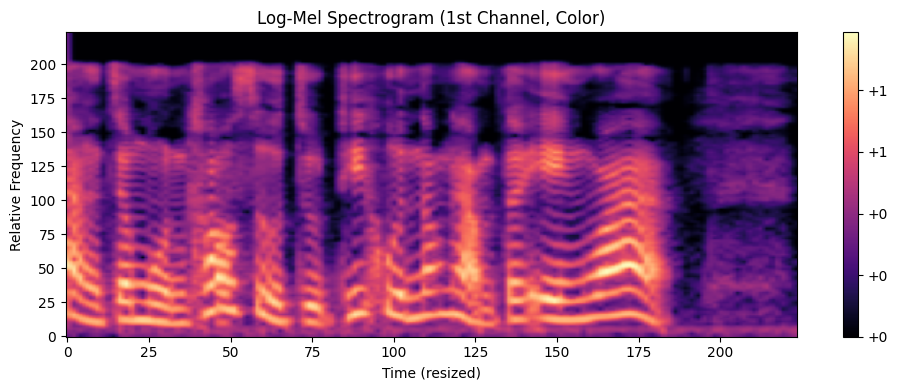

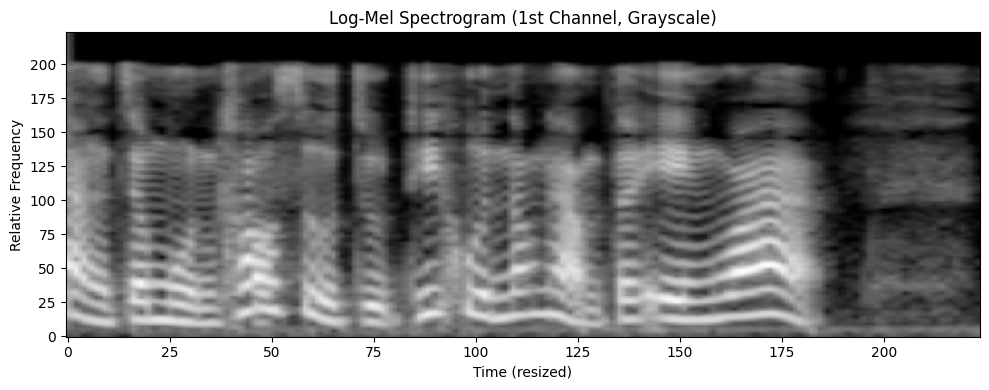


Fake


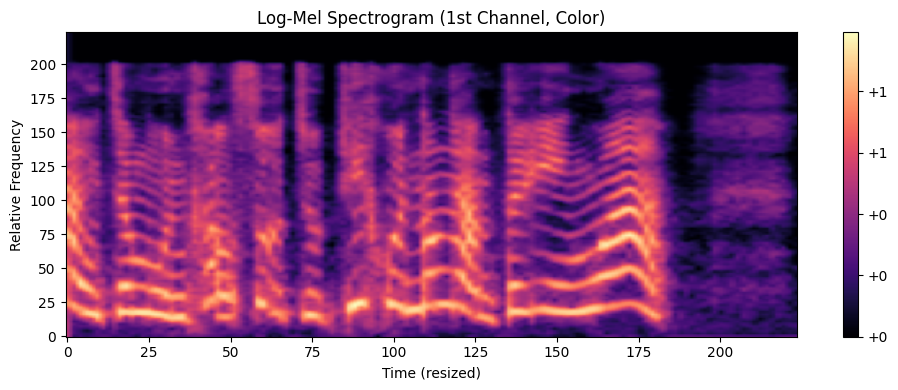

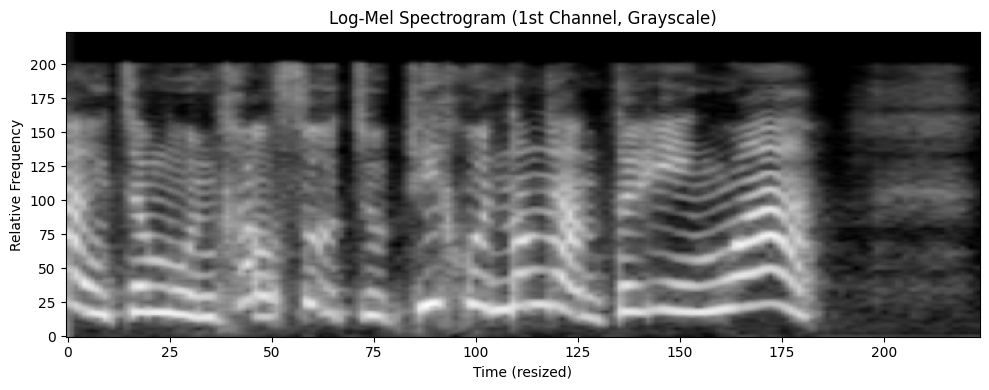

In [ ]:
path = "/content/final_data/train/real/collected_real_speaker01/speaker_01_real_008.pt"
tensor = torch.load(path)  # tensor.shape = (3, 224, 224)

print("Shape:", tensor.shape)

# display first channel
logmel = tensor[0].numpy()

# Visualization
print("Real")
plt.figure(figsize=(10, 4))
plt.imshow(logmel, aspect='auto', origin='lower', cmap='magma')
plt.title("Log-Mel Spectrogram (1st Channel, Color)")
plt.xlabel("Time (resized)")
plt.ylabel("Relative Frequency")
plt.colorbar(format="%+2.0f")
plt.tight_layout()
plt.show()
print()

# Grayscale
plt.figure(figsize=(10, 4))
plt.imshow(logmel, aspect='auto', origin='lower', cmap='gray')
plt.title("Log-Mel Spectrogram (1st Channel, Grayscale)")
plt.xlabel("Time (resized)")
plt.ylabel("Relative Frequency")
plt.tight_layout()
plt.show()
print()

path = "/content/final_data/train/fake/collected_fake_speaker01/speaker_01_fake_008.pt"
tensor = torch.load(path)  # tensor.shape = (3, 224, 224)

# display first channel
logmel = tensor[0].numpy()

# Visualization
print("Fake")
plt.figure(figsize=(10, 4))
plt.imshow(logmel, aspect='auto', origin='lower', cmap='magma')
plt.title("Log-Mel Spectrogram (1st Channel, Color)")
plt.xlabel("Time (resized)")
plt.ylabel("Relative Frequency")
plt.colorbar(format="%+2.0f")
plt.tight_layout()
plt.show()
print()

# Grayscale
plt.figure(figsize=(10, 4))
plt.imshow(logmel, aspect='auto', origin='lower', cmap='gray')
plt.title("Log-Mel Spectrogram (1st Channel, Grayscale)")
plt.xlabel("Time (resized)")
plt.ylabel("Relative Frequency")
plt.tight_layout()
plt.show()

# Training Model and Evaluate

Resnet 34 (Baseline)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 132MB/s]


Epoch  Train Loss   Val Loss   Acc      Precision  Recall     F1        
1      0.1329       0.4274     0.8128   0.7879     0.9369     0.8560    
2      0.0434       0.8066     0.7326   0.6894     1.0000     0.8162    
3      0.0088       0.2519     0.9091   0.8983     0.9550     0.9258    
4      0.0170       0.1708     0.9412   0.9098     1.0000     0.9528    
5      0.0283       3.0035     0.6738   0.6471     0.9910     0.7829    
6      0.0441       0.4581     0.8396   0.8189     0.9369     0.8739    
7      0.0242       0.8852     0.7380   0.6962     0.9910     0.8178    
8      0.0056       0.6803     0.7807   0.7365     0.9820     0.8417    
9      0.0028       0.6932     0.7754   0.7447     0.9459     0.8333    
Early stopping triggered!


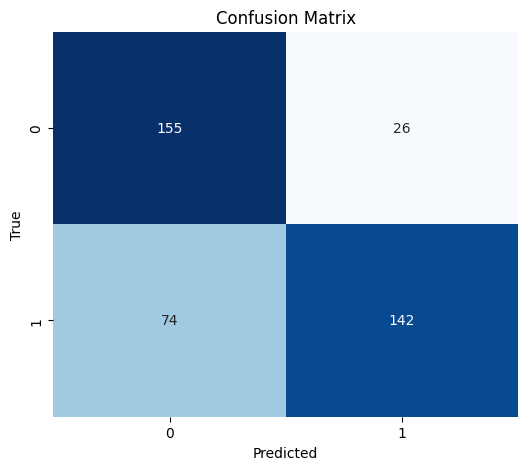

Test Results:
 Loss=0.9991, Acc=0.7481, Precision=0.8452, Recall=0.6574, F1=0.7396


In [ ]:
# Dataset
class SpectrogramDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        self.labels = []
        for label_str, label in [("real", 0), ("fake", 1)]:
            for folder in (Path(root_dir) / label_str).iterdir():
                for file in folder.glob("*.pt"):
                    self.samples.append(file)
                    self.labels.append(label)
        combined = list(zip(self.samples, self.labels))
        random.shuffle(combined)
        self.samples, self.labels = zip(*combined)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x = torch.load(self.samples[idx])
        y = self.labels[idx]
        return x, y


# ResNet34 Model with Custom Head
def get_resnet34_model():
    model = resnet34(weights=ResNet34_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = True  # Fine-tune all layers

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 2)  # changr output to 2 class
    return model


# Training & Evaluation
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device, show_confusion=False):
    model.eval()
    all_preds, all_labels = [], []
    running_loss = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            running_loss += loss.item() * x.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    avg_loss = running_loss / len(loader.dataset)

    if show_confusion:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()

    return avg_loss, acc, prec, rec, f1

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    batch_size = 32
    train_dataset = SpectrogramDataset("/content/final_data/train")
    val_dataset = SpectrogramDataset("/content/final_data/val")
    test_dataset = SpectrogramDataset("/content/final_data/test")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = get_resnet34_model().to(device)

    # Weighted Loss
    class_counts = [train_dataset.labels.count(0), train_dataset.labels.count(1)]
    class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    num_epochs = 20

    print(f"{'Epoch':<6} {'Train Loss':<12} {'Val Loss':<10} {'Acc':<8} {'Precision':<10} {'Recall':<10} {'F1':<10}")
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        print(f"{epoch+1:<6} {train_loss:<12.4f} {val_loss:<10.4f} {val_acc:<8.4f} {val_prec:<10.4f} {val_rec:<10.4f} {val_f1:<10.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "baseline_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Load best model and test
    model.load_state_dict(torch.load("baseline_model.pt"))
    test_loss, test_acc, test_prec, test_rec, test_f1 = evaluate(model, test_loader, criterion, device, show_confusion=True)
    print("Test Results:")
    print(f" Loss={test_loss:.4f}, Acc={test_acc:.4f}, Precision={test_prec:.4f}, Recall={test_rec:.4f}, F1={test_f1:.4f}")

if __name__ == "__main__":
    main()


Resnet 34 (final model)

Epoch  Train Loss   Val Loss   Acc      Precision  Recall     F1        
1      0.1969       1.8320     0.6845   0.6529     1.0000     0.7900    
2      0.0554       0.4586     0.8556   0.8559     0.9099     0.8821    
3      0.0303       2.2489     0.6631   0.6446     0.9640     0.7726    
4      0.0374       1.5526     0.7112   0.6748     0.9910     0.8029    
5      0.0097       0.7690     0.8182   0.7852     0.9550     0.8618    
6      0.0205       1.0109     0.8128   0.7794     0.9550     0.8583    
7      0.0122       1.4681     0.7647   0.7161     1.0000     0.8346    
Early stopping triggered!


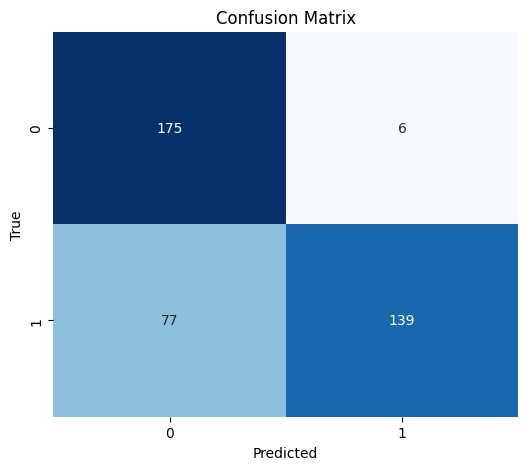

Test Results:
 Loss=0.8221, Acc=0.7909, Precision=0.9586, Recall=0.6435, F1=0.7701


In [ ]:
# Dataset
class SpectrogramDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        self.labels = []
        for label_str, label in [("real", 0), ("fake", 1)]:
            for folder in (Path(root_dir) / label_str).iterdir():
                for file in folder.glob("*.pt"):
                    self.samples.append(file)
                    self.labels.append(label)
        combined = list(zip(self.samples, self.labels))
        random.shuffle(combined)
        self.samples, self.labels = zip(*combined)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x = torch.load(self.samples[idx])
        y = self.labels[idx]
        return x, y

# ResNet34 Model with Custom Head
def get_resnet34_model():
    model = resnet34(weights=ResNet34_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = True  # Fine-tune all layers

    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 2)  # Binary output
    )
    return model

# Training & Evaluation
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device, show_confusion=False):
    model.eval()
    all_preds, all_labels = [], []
    running_loss = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            running_loss += loss.item() * x.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    avg_loss = running_loss / len(loader.dataset)

    if show_confusion:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()

    return avg_loss, acc, prec, rec, f1

# Main
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    batch_size = 32
    train_dataset = SpectrogramDataset("/content/final_data/train")
    val_dataset = SpectrogramDataset("/content/final_data/val")
    test_dataset = SpectrogramDataset("/content/final_data/test")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = get_resnet34_model().to(device)

    # Weighted Loss
    class_counts = [train_dataset.labels.count(0), train_dataset.labels.count(1)]
    class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    num_epochs = 20

    print(f"{'Epoch':<6} {'Train Loss':<12} {'Val Loss':<10} {'Acc':<8} {'Precision':<10} {'Recall':<10} {'F1':<10}")
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        print(f"{epoch+1:<6} {train_loss:<12.4f} {val_loss:<10.4f} {val_acc:<8.4f} {val_prec:<10.4f} {val_rec:<10.4f} {val_f1:<10.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "final_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Load best model and test
    model.load_state_dict(torch.load("final_model.pt"))
    test_loss, test_acc, test_prec, test_rec, test_f1 = evaluate(model, test_loader, criterion, device, show_confusion=True)
    print("Test Results:")
    print(f" Loss={test_loss:.4f}, Acc={test_acc:.4f}, Precision={test_prec:.4f}, Recall={test_rec:.4f}, F1={test_f1:.4f}")

if __name__ == "__main__":
    main()


Download Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_resnet34_model().to(device)
model.load_state_dict(torch.load('final_model.pt', map_location=device))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
! pip install torchsummary
from torchsummary import summary
model = get_resnet34_model().to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# lopo cross validation


Transfer wav files to log mel spectrogram for lopo (only normalization no augmentation)

In [ ]:
# set path
audio_root = "split_data"
spec_root = "lopo_data"

SR = 22050
N_FFT = 1024
HOP_LENGTH = 512
WIN_LENGTH = 1024
N_MELS = 128
TARGET_TIME_LEN = 128

resize_224 = Resize((224, 224))
to_tensor = ToTensor()
to_pil = ToPILImage()

# tranfer .wav file to Log Mel Spectrogram
def create_logmel_spectrogram(audio_path, save_path):
    try:
        y, _ = librosa.load(audio_path, sr=SR)
        # normalize [-1, 1]
        if np.max(np.abs(y)) > 0:
          y = y / np.max(np.abs(y))
        else:
          y = y
        mel_spec = librosa.feature.melspectrogram(
            y=y,
            sr=SR,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            win_length=WIN_LENGTH,
            n_mels=N_MELS,
            power=2.0
        )

        logmel = librosa.power_to_db(mel_spec, ref=np.max)
        logmel_norm = (logmel - logmel.min()) / (logmel.max() - logmel.min())

        tensor = torch.FloatTensor(logmel_norm).unsqueeze(0)  # (1, 128, T)

        _, n_mels, t = tensor.shape
        if t < TARGET_TIME_LEN:
            pad_amt = TARGET_TIME_LEN - t
            tensor = F.pad(tensor, (0, pad_amt))
        else:
            tensor = tensor[:, :, :TARGET_TIME_LEN]  # (1, 128, 128)

        tensor = tensor.repeat(3, 1, 1)  # (3, 128, 128)
        img = to_pil(tensor)
        img_resized = resize_224(img)
        tensor_resized = to_tensor(img_resized)  # (3, 224, 224)

        torch.save(tensor_resized, save_path)
        return True
    except Exception as e:
        print(f"❌ Error: {audio_path}: {str(e)}")
        return False

# create folder
for root, dirs, _ in os.walk(audio_root):
    for d in dirs:
        rel_path = os.path.relpath(os.path.join(root, d), audio_root)
        os.makedirs(os.path.join(spec_root, rel_path), exist_ok=True)


print("Generating spectrograms...")
count = 0
file_list = []

for root, _, files in os.walk(audio_root):
    for file in files:
        if file.lower().endswith(".wav"):
            src_path = os.path.join(root, file)
            rel_path = os.path.relpath(src_path, audio_root)
            dst_path = os.path.join(spec_root, os.path.splitext(rel_path)[0] + ".pt")
            file_list.append((src_path, dst_path))

for src, dst in tqdm(file_list, desc="Processing", bar_format="{l_bar}{bar:40}{r_bar}"):
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    if create_logmel_spectrogram(src, dst):
        count += 1

print(f"\n✅ Finish creating: {count} files")


Generating spectrograms...


Processing: 100%|████████████████████████████████████████| 2689/2689 [01:15<00:00, 35.71it/s]


✅ Finish creating: 2689 files


Example of Log Mel Spectrogram

Shape: torch.Size([3, 224, 224])
Real


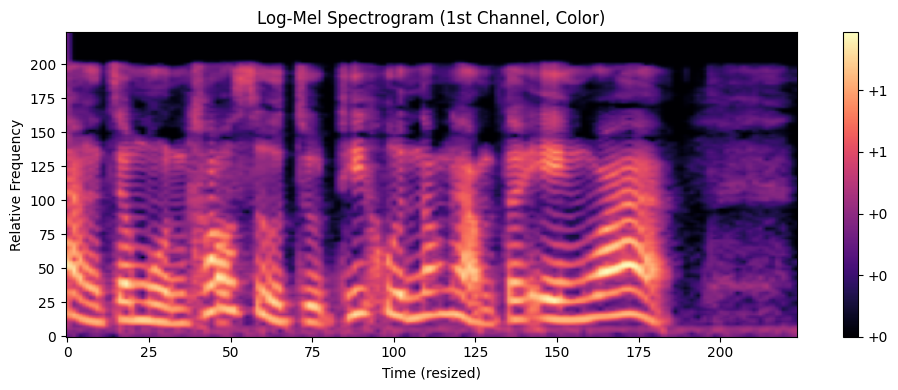

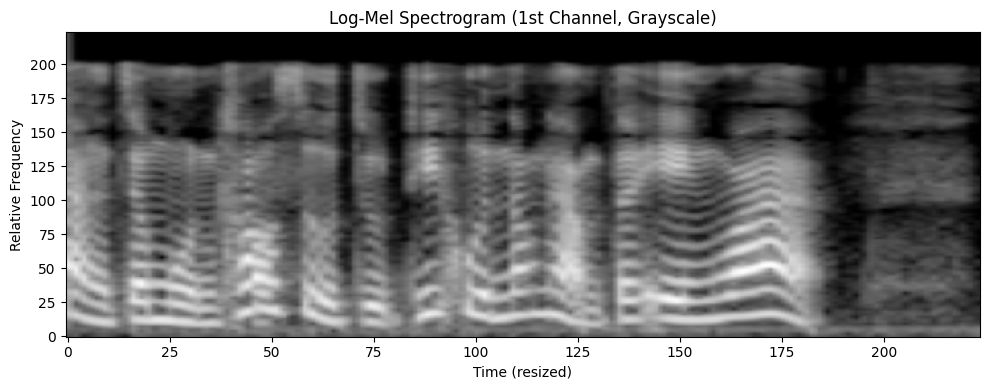

In [ ]:
path = "/content/lopo_data/train/real/collected_real_speaker01/speaker_01_real_008.pt"
tensor = torch.load(path)  # tensor.shape = (3, 224, 224)

print("Shape:", tensor.shape)

# display first channel
logmel = tensor[0].numpy()

# Visualization
print("Real")
plt.figure(figsize=(10, 4))
plt.imshow(logmel, aspect='auto', origin='lower', cmap='magma')
plt.title("Log-Mel Spectrogram (1st Channel, Color)")
plt.xlabel("Time (resized)")
plt.ylabel("Relative Frequency")
plt.colorbar(format="%+2.0f")
plt.tight_layout()
plt.show()
print()

# Grayscale
plt.figure(figsize=(10, 4))
plt.imshow(logmel, aspect='auto', origin='lower', cmap='gray')
plt.title("Log-Mel Spectrogram (1st Channel, Grayscale)")
plt.xlabel("Time (resized)")
plt.ylabel("Relative Frequency")
plt.tight_layout()
plt.show()
print()

In [ ]:
# LOPO Baseline

DATA_ROOT = "/content/lopo_data"
lopo_pairs = [
    (["ryan-original", "margot-original"], ["ryan-to-taylor", "margot-to-musk"]),
    ("biden-original", "biden-to-Obama"),
    ("linus-original", "linus-to-taylor"),
    ("musk-original", "musk-to-margot"),
    ("obama-original", "Obama-to-Biden"),
    ("taylor-original", "taylor-to-ryan"),
    ("trump-original", "trump-to-Obama"),
    ("collected_real_speaker01", "collected_fake_speaker01"),
    ("collected_real_speaker02", "collected_fake_speaker02"),
    ("collected_real_speaker03", "collected_fake_speaker03"),
    ("collected_real_speaker04", "collected_fake_speaker04"),
    ("collected_real_speaker05", "collected_fake_speaker05"),
    ("collected_real_speaker06", "collected_fake_speaker06"),
    ("collected_real_speaker07", ["collected_fake_speaker07", "collected_fake_speaker08", "collected_fake_speaker09"]),
    ("collected_real_speaker08", ["collected_fake_speaker10", "collected_fake_speaker11", "collected_fake_speaker12"]),
    ("collected_real_speaker09", ["collected_fake_speaker13", "collected_fake_speaker14", "collected_fake_speaker15"]),
    ("collected_real_speaker10", ["collected_fake_speaker16", "collected_fake_speaker17", "collected_fake_speaker18"]),
    ("collected_real_speaker10", ["collected_fake_speaker18", "collected_fake_speaker19"]),
]

# DATASET
def get_files_for_speaker(root_dir, speaker, label_type):
    files = []
    for split in ['train', 'val', 'test']:
        folder = os.path.join(root_dir, split, label_type, speaker)
        if os.path.exists(folder):
            files += glob(os.path.join(folder, "*.pt"))
    return files

class SpectrogramDataset(Dataset):
    def __init__(self, file_label_list):
        self.data = file_label_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        tensor = torch.load(path)
        return tensor, label

def prepare_lopo_fold(DATA_ROOT, real_spk, fake_spk):
    # แปลงให้เป็น list เสมอ
    real_spk_list = [real_spk] if isinstance(real_spk, str) else real_spk
    fake_spk_list = [fake_spk] if isinstance(fake_spk, str) else fake_spk

    test_real = []
    for spk in real_spk_list:
        test_real += get_files_for_speaker(DATA_ROOT, spk, 'real')

    test_fake = []
    for spk in fake_spk_list:
        test_fake += get_files_for_speaker(DATA_ROOT, spk, 'fake')

    test_files = [(f, 0) for f in test_real] + [(f, 1) for f in test_fake]

    train_real, train_fake = [], []
    for split in ['train', 'val']:
        real_dir = os.path.join(DATA_ROOT, split, 'real')
        if os.path.exists(real_dir):
            for spk in os.listdir(real_dir):
                if spk not in real_spk_list:
                    train_real += get_files_for_speaker(DATA_ROOT, spk, 'real')

        fake_dir = os.path.join(DATA_ROOT, split, 'fake')
        if os.path.exists(fake_dir):
            for spk in os.listdir(fake_dir):
                if spk not in fake_spk_list:
                    train_fake += get_files_for_speaker(DATA_ROOT, spk, 'fake')

    train_files = [(f, 0) for f in train_real] + [(f, 1) for f in train_fake]
    return train_files, test_files


# MODEL (Baseline)
def get_resnet34_model():
    model = resnet34(weights=ResNet34_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = True  # Fine-tune all layers

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 2)  # Single linear head
    return model

# MAIN TRAINING
def main():
    results = []
    all_conf_matrices = []

    for i, (real_spk, fake_spk) in enumerate(lopo_pairs):
        print(f"\n==== LOPO Fold {i+1}: Real '{real_spk}' <-> Fake '{fake_spk}' ====")
        train_files, test_files = prepare_lopo_fold(DATA_ROOT, real_spk, fake_spk)

        train_dataset = SpectrogramDataset(train_files)
        test_dataset = SpectrogramDataset(test_files)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32)

        model = get_resnet34_model()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # Early Stopping
        best_loss = float('inf')
        patience = 5
        patience_counter = 0
        num_epochs = 10


        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            avg_loss = running_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

            # Early stopping check
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
                torch.save(model.state_dict(), "best_model.pt")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered!")
                    break

        model.load_state_dict(torch.load("best_model.pt"))
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        cm = confusion_matrix(y_true, y_pred)

        precision = report['1']['precision']
        recall = report['1']['recall']
        f1 = report['1']['f1-score']
        acc = report['accuracy']
        results.append({
            "Fold": i+1,
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "Accuracy": acc,
            "Loss": best_loss
        })
        all_conf_matrices.append(cm)

    # Show Confusion Matrices First
    print("\n=== Confusion Matrices ===")
    for i, cm in enumerate(all_conf_matrices):
        print(f"\nFold {i+1}:")
        print(tabulate([
            ["Actual: Real", cm[0][0], cm[0][1]],
            ["Actual: Fake", cm[1][0], cm[1][1]]
        ], headers=["", "Pred: Real", "Pred: Fake"]))

    # Then Show Performance Summary
    print("\n=== Performance Metrics ===")
    headers = ["Fold", "Precision", "Recall", "F1", "Accuracy", "Loss"]
    table = [[r["Fold"], r["Precision"], r["Recall"], r["F1"], r["Accuracy"], r["Loss"]] for r in results]
    avg = {
        "Fold": "Avg",
        "Precision": np.mean([r["Precision"] for r in results]),
        "Recall": np.mean([r["Recall"] for r in results]),
        "F1": np.mean([r["F1"] for r in results]),
        "Accuracy": np.mean([r["Accuracy"] for r in results]),
        "Loss": np.mean([r["Loss"] for r in results])
    }
    table.append([avg["Fold"], avg["Precision"], avg["Recall"], avg["F1"], avg["Accuracy"], avg["Loss"]])
    print(tabulate(table, headers=headers, floatfmt=".4f"))

if __name__ == "__main__":
    main()



==== LOPO Fold 1: Real '['ryan-original', 'margot-original']' <-> Fake '['ryan-to-taylor', 'margot-to-musk']' ====
Epoch 1/10 - Loss: 0.1809
Epoch 2/10 - Loss: 0.0428
Epoch 3/10 - Loss: 0.0260
Epoch 4/10 - Loss: 0.0241
Epoch 5/10 - Loss: 0.0177
Epoch 6/10 - Loss: 0.0193
Epoch 7/10 - Loss: 0.0071
Epoch 8/10 - Loss: 0.0305
Epoch 9/10 - Loss: 0.0086
Epoch 10/10 - Loss: 0.0026

==== LOPO Fold 2: Real 'biden-original' <-> Fake 'biden-to-Obama' ====
Epoch 1/10 - Loss: 0.1802
Epoch 2/10 - Loss: 0.0810
Epoch 3/10 - Loss: 0.0396
Epoch 4/10 - Loss: 0.0635
Epoch 5/10 - Loss: 0.0718
Epoch 6/10 - Loss: 0.0476
Epoch 7/10 - Loss: 0.0225
Epoch 8/10 - Loss: 0.0048
Epoch 9/10 - Loss: 0.0040
Epoch 10/10 - Loss: 0.0080

==== LOPO Fold 3: Real 'linus-original' <-> Fake 'linus-to-taylor' ====
Epoch 1/10 - Loss: 0.1672
Epoch 2/10 - Loss: 0.0538
Epoch 3/10 - Loss: 0.0146
Epoch 4/10 - Loss: 0.0189
Epoch 5/10 - Loss: 0.0110
Epoch 6/10 - Loss: 0.0323
Epoch 7/10 - Loss: 0.0171
Epoch 8/10 - Loss: 0.0172
Epoch 9/1

In [ ]:
# LOPO

DATA_ROOT = "/content/lopo_data"
lopo_pairs = [
    (["ryan-original", "margot-original"], ["ryan-to-taylor", "margot-to-musk"]),
    ("biden-original", "biden-to-Obama"),
    ("linus-original", "linus-to-taylor"),
    ("musk-original", "musk-to-margot"),
    ("obama-original", "Obama-to-Biden"),
    ("taylor-original", "taylor-to-ryan"),
    ("trump-original", "trump-to-Obama"),
    ("collected_real_speaker01", "collected_fake_speaker01"),
    ("collected_real_speaker02", "collected_fake_speaker02"),
    ("collected_real_speaker03", "collected_fake_speaker03"),
    ("collected_real_speaker04", "collected_fake_speaker04"),
    ("collected_real_speaker05", "collected_fake_speaker05"),
    ("collected_real_speaker06", "collected_fake_speaker06"),
    ("collected_real_speaker07", ["collected_fake_speaker07", "collected_fake_speaker08", "collected_fake_speaker09"]),
    ("collected_real_speaker08", ["collected_fake_speaker10", "collected_fake_speaker11", "collected_fake_speaker12"]),
    ("collected_real_speaker09", ["collected_fake_speaker13", "collected_fake_speaker14", "collected_fake_speaker15"]),
    ("collected_real_speaker10", ["collected_fake_speaker16", "collected_fake_speaker17", "collected_fake_speaker18"]),
    ("collected_real_speaker10", ["collected_fake_speaker18", "collected_fake_speaker19"]),
]

# DATASET
def get_files_for_speaker(root_dir, speaker, label_type):
    files = []
    for split in ['train', 'val', 'test']:
        folder = os.path.join(root_dir, split, label_type, speaker)
        if os.path.exists(folder):
            files += glob(os.path.join(folder, "*.pt"))
    return files

class SpectrogramDataset(Dataset):
    def __init__(self, file_label_list):
        self.data = file_label_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        tensor = torch.load(path)
        return tensor, label

def prepare_lopo_fold(DATA_ROOT, real_spk, fake_spk):
    # แปลงให้เป็น list เสมอ
    real_spk_list = [real_spk] if isinstance(real_spk, str) else real_spk
    fake_spk_list = [fake_spk] if isinstance(fake_spk, str) else fake_spk

    test_real = []
    for spk in real_spk_list:
        test_real += get_files_for_speaker(DATA_ROOT, spk, 'real')

    test_fake = []
    for spk in fake_spk_list:
        test_fake += get_files_for_speaker(DATA_ROOT, spk, 'fake')

    test_files = [(f, 0) for f in test_real] + [(f, 1) for f in test_fake]

    train_real, train_fake = [], []
    for split in ['train', 'val']:
        real_dir = os.path.join(DATA_ROOT, split, 'real')
        if os.path.exists(real_dir):
            for spk in os.listdir(real_dir):
                if spk not in real_spk_list:
                    train_real += get_files_for_speaker(DATA_ROOT, spk, 'real')

        fake_dir = os.path.join(DATA_ROOT, split, 'fake')
        if os.path.exists(fake_dir):
            for spk in os.listdir(fake_dir):
                if spk not in fake_spk_list:
                    train_fake += get_files_for_speaker(DATA_ROOT, spk, 'fake')

    train_files = [(f, 0) for f in train_real] + [(f, 1) for f in train_fake]
    return train_files, test_files


# ResNet34 Model with Custom Head
def get_resnet34_model():
    model = resnet34(weights=ResNet34_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = True  # Fine-tune all layers

    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 2)  # Binary output
    )
    return model

# MAIN TRAINING
def main():
    results = []
    all_conf_matrices = []

    for i, (real_spk, fake_spk) in enumerate(lopo_pairs):
        print(f"\n==== LOPO Fold {i+1}: Real '{real_spk}' <-> Fake '{fake_spk}' ====")
        train_files, test_files = prepare_lopo_fold(DATA_ROOT, real_spk, fake_spk)

        train_dataset = SpectrogramDataset(train_files)
        test_dataset = SpectrogramDataset(test_files)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32)

        model = get_resnet34_model()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # Early Stopping
        best_loss = float('inf')
        patience = 5
        patience_counter = 0
        num_epochs = 10


        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            avg_loss = running_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

            # Early stopping check
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
                torch.save(model.state_dict(), "best_model.pt")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered!")
                    break

        model.load_state_dict(torch.load("best_model.pt"))
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        cm = confusion_matrix(y_true, y_pred)

        precision = report['1']['precision']
        recall = report['1']['recall']
        f1 = report['1']['f1-score']
        acc = report['accuracy']
        results.append({
            "Fold": i+1,
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "Accuracy": acc,
            "Loss": best_loss
        })
        all_conf_matrices.append(cm)

    # Show Confusion Matrices First
    print("\n=== Confusion Matrices ===")
    for i, cm in enumerate(all_conf_matrices):
        print(f"\nFold {i+1}:")
        print(tabulate([
            ["Actual: Real", cm[0][0], cm[0][1]],
            ["Actual: Fake", cm[1][0], cm[1][1]]
        ], headers=["", "Pred: Real", "Pred: Fake"]))

    # Then Show Performance Summary
    print("\n=== Performance Metrics ===")
    headers = ["Fold", "Precision", "Recall", "F1", "Accuracy", "Loss"]
    table = [[r["Fold"], r["Precision"], r["Recall"], r["F1"], r["Accuracy"], r["Loss"]] for r in results]
    avg = {
        "Fold": "Avg",
        "Precision": np.mean([r["Precision"] for r in results]),
        "Recall": np.mean([r["Recall"] for r in results]),
        "F1": np.mean([r["F1"] for r in results]),
        "Accuracy": np.mean([r["Accuracy"] for r in results]),
        "Loss": np.mean([r["Loss"] for r in results])
    }
    table.append([avg["Fold"], avg["Precision"], avg["Recall"], avg["F1"], avg["Accuracy"], avg["Loss"]])
    print(tabulate(table, headers=headers, floatfmt=".4f"))

if __name__ == "__main__":
    main()



==== LOPO Fold 1: Real '['ryan-original', 'margot-original']' <-> Fake '['ryan-to-taylor', 'margot-to-musk']' ====
Epoch 1/10 - Loss: 0.3623
Epoch 2/10 - Loss: 0.0823
Epoch 3/10 - Loss: 0.0499
Epoch 4/10 - Loss: 0.0263
Epoch 5/10 - Loss: 0.0283
Epoch 6/10 - Loss: 0.0245
Epoch 7/10 - Loss: 0.0316
Epoch 8/10 - Loss: 0.0068
Epoch 9/10 - Loss: 0.0035
Epoch 10/10 - Loss: 0.0168

==== LOPO Fold 2: Real 'biden-original' <-> Fake 'biden-to-Obama' ====
Epoch 1/10 - Loss: 0.3199
Epoch 2/10 - Loss: 0.0780
Epoch 3/10 - Loss: 0.0755
Epoch 4/10 - Loss: 0.1247
Epoch 5/10 - Loss: 0.0585
Epoch 6/10 - Loss: 0.0160
Epoch 7/10 - Loss: 0.0107
Epoch 8/10 - Loss: 0.0182
Epoch 9/10 - Loss: 0.0239
Epoch 10/10 - Loss: 0.0330

==== LOPO Fold 3: Real 'linus-original' <-> Fake 'linus-to-taylor' ====
Epoch 1/10 - Loss: 0.3453
Epoch 2/10 - Loss: 0.0909
Epoch 3/10 - Loss: 0.0357
Epoch 4/10 - Loss: 0.0350
Epoch 5/10 - Loss: 0.0288
Epoch 6/10 - Loss: 0.0304
Epoch 7/10 - Loss: 0.0388
Epoch 8/10 - Loss: 0.0162
Epoch 9/1